**Kaggle data set loading and environment**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cleanedtweet/cleaned_tweets.pkl
/kaggle/input/data-mining-lab-2-db/tweets_DM.json
/kaggle/input/data-mining-lab-2-db/sampleSubmission.csv
/kaggle/input/data-mining-lab-2-db/data_identification.csv
/kaggle/input/data-mining-lab-2-db/emotion.csv


In [2]:
# !pip install contractions
# !pip install spacy
# !pip install -U emoji

**Libraries**

In [3]:
import json
import matplotlib.pyplot as plt
import gc  
import string
import re
from wordcloud import WordCloud
# import contractions
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import re
import emoji
import regex # count features
from textblob import TextBlob

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Dependencies**

In [4]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Loading and Exploration 

In [5]:
# Load JSON data
tweets_data = []

with open('/kaggle/input/data-mining-lab-2-db/tweets_DM.json', 'r', encoding='utf-8') as file:
    for line in file:
        tweet = json.loads(line)
        tweets_data.append({
            'tweet_id': tweet['_source']['tweet']['tweet_id'],
            'text': tweet['_source']['tweet']['text']
        })

# Convert to DataFrame
tweets_df = pd.DataFrame(tweets_data)

# Display the first few rows of the DataFrame
print(tweets_df.head())


   tweet_id                                               text
0  0x376b20  People who post "add me on #Snapchat" must be ...
1  0x2d5350  @brianklaas As we see, Trump is dangerous to #...
2  0x28b412  Confident of your obedience, I write to you, k...
3  0x1cd5b0                Now ISSA is stalking Tasha 😂😂😂 <LH>
4  0x2de201  "Trust is not the same as faith. A friend is s...


In [6]:
# Display additional information on the tweets dataframe
print('Dataset size:',tweets_df.shape)
print('Columns are:',tweets_df.columns)


Dataset size: (1867535, 2)
Columns are: Index(['tweet_id', 'text'], dtype='object')


In [7]:
# Check for missing values
missing_values = tweets_df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
tweet_id    0
text        0
dtype: int64


In [8]:
# Check for duplicate rows based on all columns
duplicate_rows = tweets_df[tweets_df.duplicated()]

# Count the number of duplicate rows
num_duplicate_rows = len(duplicate_rows)
print(f"\nNumber of duplicate rows: {num_duplicate_rows}")


Number of duplicate rows: 0


In [9]:
# # Word Cloud Visualization

# # Concatenate all tweets text into a single string
# all_text = ' '.join(tweets_df['text'].astype(str))

# # Generate a word cloud
# wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(all_text)

# # Display the word cloud using matplotlib
# plt.figure(figsize=(10, 6))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.title('Word Cloud for Tweets')
# plt.show()


In [10]:
# Load emotion data
emotion_data = pd.read_csv('/kaggle/input/data-mining-lab-2-db/emotion.csv')

# Display the first few rows of the emotion data
print(emotion_data.head())



   tweet_id       emotion
0  0x3140b1       sadness
1  0x368b73       disgust
2  0x296183  anticipation
3  0x2bd6e1           joy
4  0x2ee1dd  anticipation


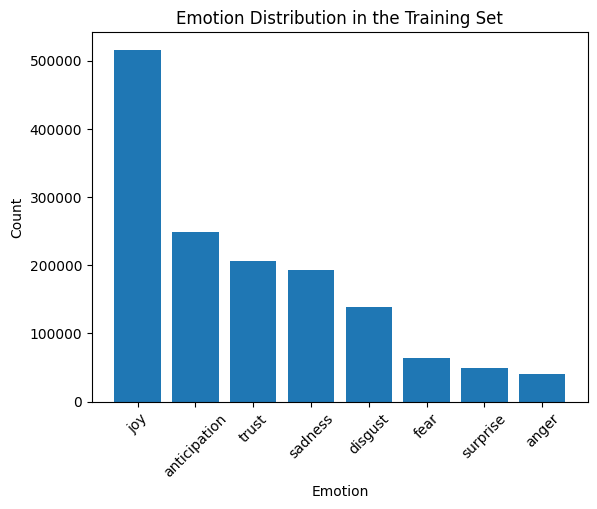

In [11]:
# Plot emotion distribution
emotion_counts = emotion_data['emotion'].value_counts()
plt.bar(emotion_counts.index, emotion_counts.values)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Distribution in the Training Set')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

In [12]:
# Show emotion distribution (text version)
print("Emotion Distribution in the Training Set:")
for index, count in emotion_counts.items():
    print(f"{index}: {count} tweets")


Emotion Distribution in the Training Set:
joy: 516017 tweets
anticipation: 248935 tweets
trust: 205478 tweets
sadness: 193437 tweets
disgust: 139101 tweets
fear: 63999 tweets
surprise: 48729 tweets
anger: 39867 tweets


In [13]:
# Load data identification data
data_identification = pd.read_csv('/kaggle/input/data-mining-lab-2-db/data_identification.csv')

# Display the first few rows of the data identification data
print(data_identification.head())


   tweet_id identification
0  0x28cc61           test
1  0x29e452          train
2  0x2b3819          train
3  0x2db41f           test
4  0x2a2acc          train


In [14]:
# Check unique values in the identification column
unique_values = data_identification['identification'].unique()
print("Unique values in identification column:", unique_values)

Unique values in identification column: ['test' 'train']


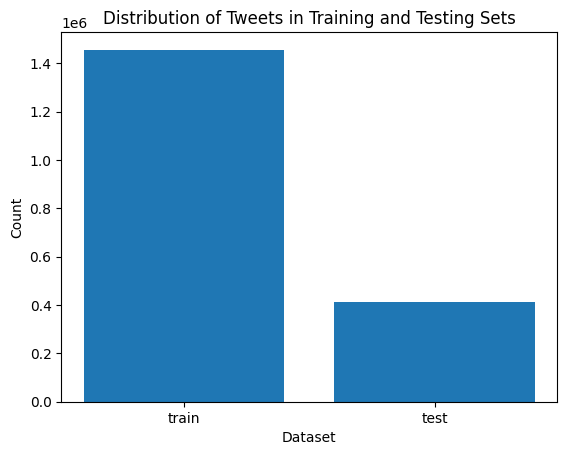

In [15]:
# Plot distribution of tweets in the training and testing sets
identification_counts = data_identification['identification'].value_counts()
plt.bar(identification_counts.index, identification_counts.values)
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.title('Distribution of Tweets in Training and Testing Sets')
plt.show()

In [16]:
# Show distribution of tweets in the training and testing sets (text version)
print("Distribution of Tweets in Training and Testing Sets:")
for index, count in identification_counts.items():
    print(f"{index}: {count} tweets")


Distribution of Tweets in Training and Testing Sets:
train: 1455563 tweets
test: 411972 tweets


In [17]:
# Load sample submission data
sample_submission = pd.read_csv('/kaggle/input/data-mining-lab-2-db/sampleSubmission.csv')

# Display the first few rows of the sample submission data
print(sample_submission.head())


         id   emotion
0  0x2c7743  surprise
1  0x2c1eed  surprise
2  0x2826ea  surprise
3  0x356d9a  surprise
4  0x20fd95  surprise


# Data Cleaning

In [18]:
# This is a comprehensive cleaning where I remove, special characters (puntuations, syymbols), URLs and stop words. 
# I also ran a contraction code which will make the tokenization process more efficient. for exxample the tokenizer 
# won't have to recognize can't and cannot as two seperate words but as a single word "cannot". The code also lemmetizes
# the data frame so it can easily detect root words. for example detecting "anger" in the word angry.

In [19]:
# # Load spaCy English model
# nlp = spacy.load("en_core_web_sm")

# # A function to define text cleaning using spaCy. This code also preserves emojis for sentimental analysis. 

# def clean_text_spacy_with_emojis(text):
#     # Convert text to lowercase
#     text = text.lower()
    
#     # Remove URLs and user mentions
#     text = re.sub(r"http\S+|www\S+|https\S+|\@\w+|\#", "", text, flags=re.MULTILINE)
#     # Expand contractions
#     text = contractions.fix(text)
    
#     # Use spaCy for tokenization and lemmatization
#     doc = nlp(text)
    
#     # Preserve emojis by converting them to their descriptions
#     emojis_preserved = [emoji.demojize(token.text) if emoji.demojize(token.text) != token.text else token.lemma_ 
#                         for token in doc if token.is_alpha and token.lemma_ not in nlp.Defaults.stop_words]
    
#     lemmatized_text = " ".join(emojis_preserved)
    
#     return lemmatized_text

# tweets_df['cleaned_text_with_emojis'] = tweets_df['text'].apply(clean_text_spacy_with_emojis)

# # Display the dataframe with the cleaned text
# print(tweets_df[['text', 'cleaned_text_with_emojis']])

In [20]:
# Save the cleaned DataFrame to a pickle file for easier access in the future (saves alot of time)

In [21]:
# Load the Pickle file into a DataFrame
cleaned_tweet_df = pd.read_pickle('/kaggle/input/cleanedtweet/cleaned_tweets.pkl')


**Cleaned data: Quick Access**

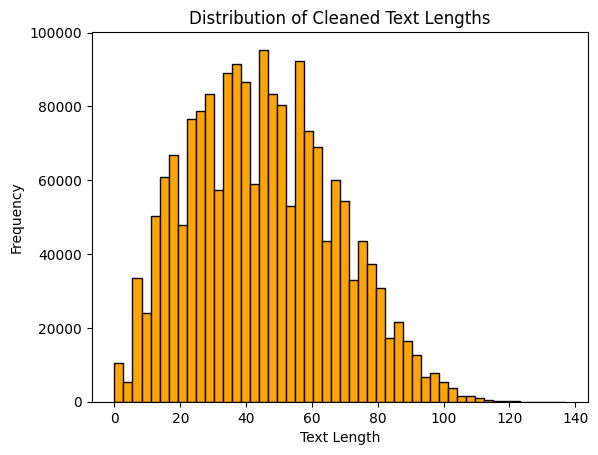

In [22]:
# Distribution of cleaned text lengths
cleaned_tweet_df['text_length'] = cleaned_tweet_df['cleaned_text_with_emojis'].apply(len)
plt.hist(cleaned_tweet_df['text_length'], bins=50, color='orange', edgecolor='black')
plt.title('Distribution of Cleaned Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


**Merging Data Sets** 

In [23]:
# Merge Identification Data with cleaned tweets
merged_data = pd.merge(cleaned_tweet_df, data_identification, on='tweet_id')

# Display the merged data
print(merged_data.head())

   tweet_id                                               text  \
0  0x376b20  People who post "add me on #Snapchat" must be ...   
1  0x2d5350  @brianklaas As we see, Trump is dangerous to #...   
2  0x28b412  Confident of your obedience, I write to you, k...   
3  0x1cd5b0                Now ISSA is stalking Tasha 😂😂😂 <LH>   
4  0x2de201  "Trust is not the same as faith. A friend is s...   

                            cleaned_text_with_emojis  text_length  \
0    people post add I snapchat dehydrate cuz man lh           47   
1  trump dangerous freepress world lh lh trumpleg...           53   
2  confident obedience I write know I ask philemo...           64   
3                                issa stalk tasha lh           19   
4  trust faith friend trust faith mistake christo...           65   

  identification  
0          train  
1          train  
2           test  
3          train  
4           test  


In [25]:
train_df = merged_data[merged_data['identification'] == 'train']
test_df = merged_data[merged_data['identification'] == 'test']

In [26]:
# Display the head of train_df
print("Train DataFrame:")
print(train_df.head())

# Display the head of test_df
print("\nTest DataFrame:")
print(test_df.head())

Train DataFrame:
   tweet_id                                               text  \
0  0x376b20  People who post "add me on #Snapchat" must be ...   
1  0x2d5350  @brianklaas As we see, Trump is dangerous to #...   
3  0x1cd5b0                Now ISSA is stalking Tasha 😂😂😂 <LH>   
5  0x1d755c  @RISKshow @TheKevinAllison Thx for the BEST TI...   
6  0x2c91a8       Still waiting on those supplies Liscus. <LH>   

                            cleaned_text_with_emojis  text_length  \
0    people post add I snapchat dehydrate cuz man lh           47   
1  trump dangerous freepress world lh lh trumpleg...           53   
3                                issa stalk tasha lh           19   
5  thank good time tonight story heartbreakingly ...           76   
6                              wait supply liscus lh           21   

  identification  
0          train  
1          train  
3          train  
5          train  
6          train  

Test DataFrame:
    tweet_id                            

In [27]:
# Merge train data with emotion data
train_df = pd.merge(train_df, emotion_data, on='tweet_id')

# Display the head of the updated train_df
print(train_df.head())

   tweet_id                                               text  \
0  0x376b20  People who post "add me on #Snapchat" must be ...   
1  0x2d5350  @brianklaas As we see, Trump is dangerous to #...   
2  0x1cd5b0                Now ISSA is stalking Tasha 😂😂😂 <LH>   
3  0x1d755c  @RISKshow @TheKevinAllison Thx for the BEST TI...   
4  0x2c91a8       Still waiting on those supplies Liscus. <LH>   

                            cleaned_text_with_emojis  text_length  \
0    people post add I snapchat dehydrate cuz man lh           47   
1  trump dangerous freepress world lh lh trumpleg...           53   
2                                issa stalk tasha lh           19   
3  thank good time tonight story heartbreakingly ...           76   
4                              wait supply liscus lh           21   

  identification       emotion  
0          train  anticipation  
1          train       sadness  
2          train          fear  
3          train           joy  
4          train  antic

# Feature Engineering

In [30]:
# Check for missing values in the training set
missing_values_train = train_df.isnull().sum()
print("Missing Values in Training Set:")
print(missing_values_train)

# Check for missing values in the testing set
missing_values_test = test_df.isnull().sum()
print("\nMissing Values in Testing Set:")
print(missing_values_test)

Missing Values in Training Set:
tweet_id                    0
text                        0
cleaned_text_with_emojis    0
text_length                 0
identification              0
emotion                     0
dtype: int64

Missing Values in Testing Set:
tweet_id                    0
text                        0
cleaned_text_with_emojis    0
text_length                 0
identification              0
dtype: int64


In [29]:
# After having tried the count feature and receiving the "AttributeError: 'float' object has no attribute 'split' error, I checked for
# missing values only to realize that all the data in test data set are missing values, It only contains the  Identification and twee
# id column. Therefore, I made adjustents to the code below.

In [ ]:
# # 1. Word Count
# train_df.loc[:, 'word_count'] = train_df['cleaned_text_with_emojis'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
# test_df.loc[:, 'word_count'] = test_df['cleaned_text_with_emojis'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

# # 2. Exclamation Mark Count
# train_df.loc[:, 'exclamation_count'] = train_df['cleaned_text_with_emojis'].apply(lambda x: x.count('!') if isinstance(x, str) else 0)
# test_df.loc[:, 'exclamation_count'] = test_df['cleaned_text_with_emojis'].apply(lambda x: x.count('!') if isinstance(x, str) else 0)

# # 3. Question Mark Count
# train_df.loc[:, 'question_count'] = train_df['cleaned_text_with_emojis'].apply(lambda x: x.count('?') if isinstance(x, str) else 0)
# test_df.loc[:, 'question_count'] = test_df['cleaned_text_with_emojis'].apply(lambda x: x.count('?') if isinstance(x, str) else 0)

# # 4. Emoji Count
# train_df.loc[:, 'emoji_count'] = train_df['cleaned_text_with_emojis'].apply(lambda x: len(regex.findall(r'\p{So}', x)) if isinstance(x, str) else 0)
# test_df.loc[:, 'emoji_count'] = test_df['cleaned_text_with_emojis'].apply(lambda x: len(regex.findall(r'\p{So}', x)) if isinstance(x, str) else 0)

# # 5. Uppercase Words Count
# train_df.loc[:, 'uppercase_count'] = train_df['cleaned_text_with_emojis'].apply(lambda x: len([word for word in x.split() if word.isupper()]) if isinstance(x, str) else 0)
# test_df.loc[:, 'uppercase_count'] = test_df['cleaned_text_with_emojis'].apply(lambda x: len([word for word in x.split() if word.isupper()]) if isinstance(x, str) else 0)

# # 6. Punctuation Count
# train_df.loc[:, 'punctuation_count'] = train_df['cleaned_text_with_emojis'].apply(lambda x: len([char for char in x if char in string.punctuation]) if isinstance(x, str) else 0)
# test_df.loc[:, 'punctuation_count'] = test_df['cleaned_text_with_emojis'].apply(lambda x: len([char for char in x if char in string.punctuation]) if isinstance(x, str) else 0)


In [ ]:
# # This will calculate sentiment using a sentiment analysis algorithm by TextBlob.
# # For example, it assigns positive emotions such as happiness and trust to "1",
# # anger and sadness as "-1", and any other as "Neutral" (which is "0").
# # Thus, the numbers closest to the integer would be categorized as that sentiment.
# # For example, a sentiment score of 0.55 would be positive while -0.6 would be negative.

# # Define a function to apply sentiment analysis
# def calculate_sentiment(text):
#     # Check if the text is not NaN (dealing with NaN values in the test dataset)
#     if isinstance(text, str):
#         # Return the sentiment polarity
#         return TextBlob(text).sentiment.polarity
#     else:
#         # Return NaN for missing values
# #         return float('nan'

# # Apply sentiment analysis to the 'cleaned_text_with_emojis' column in both train and test dataframes
# train_df['sentiment_score'] = train_df['cleaned_text_with_emojis'].apply(calculate_sentiment)
# test_df['sentiment_score'] = test_df['cleaned_text_with_emojis'].apply(calculate_sentiment)

# Model Training

**roBERTa Model**

In [ ]:
# from transformers import RobertaTokenizer

# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# # Tokenize the text
# train_tokens = tokenizer(train_df['cleaned_text_with_emojis'].tolist(), padding=True, truncation=True, return_tensors='pt')
# test_tokens = tokenizer(test_df['cleaned_text_with_emojis'].tolist(), padding=True, truncation=True, return_tensors='pt')


In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# # Tokenize the text
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# train_tokens = tokenizer(train_df['cleaned_text_with_emojis'].tolist(), padding=True, truncation=True, return_tensors='pt')
# test_tokens = tokenizer(test_df['cleaned_text_with_emojis'].tolist(), padding=True, truncation=True, return_tensors='pt')

# # Convert emotion labels to numerical values
# emotion_mapping = {'joy': 0, 'anticipation': 1, 'trust': 2, 'sadness': 3, 'disgust': 4, 'fear': 5, 'surprise': 6, 'anger': 7}
# train_df['emotion_label'] = train_df['emotion'].map(emotion_mapping)

# # Split the dataset into train and validation sets
# train_data, val_data, train_labels, val_labels = train_test_split(
#     train_tokens['input_ids'], 
#     train_df['emotion_label'].tolist(), 
#     test_size=0.1, 
#     random_state=42
# )

# # Define a custom dataset class
# class CustomDataset(Dataset):
#     def __init__(self, input_ids, attention_masks, labels):
#         self.input_ids = input_ids
#         self.attention_masks = attention_masks
#         self.labels = labels

#     def __len__(self):
#         return len(self.input_ids)

#     def __getitem__(self, idx):
#         return {
#             'input_ids': self.input_ids[idx],
#             'attention_mask': self.attention_masks[idx],
#             'labels': torch.tensor(self.labels[idx], dtype=torch.long)
#         }

# # Create DataLoader for training and validation sets
# train_dataset = CustomDataset(train_data, train_tokens['attention_mask'], train_labels)
# val_dataset = CustomDataset(val_data, train_tokens['attention_mask'], val_labels)

# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# # Load pre-trained Roberta model
# model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=8)

# # Set up optimizer and learning rate scheduler
# optimizer = AdamW(model.parameters(), lr=5e-5)
# epochs = 3

# # Training loop
# for epoch in range(epochs):
#     model.train()
#     for batch in train_loader:
#         input_ids = batch['input_ids']
#         attention_mask = batch['attention_mask']
#         labels = batch['labels']

#         optimizer.zero_grad()

#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()

#     # Validation loop
#     model.eval()
#     all_val_labels = []
#     all_val_preds = []
#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids = batch['input_ids']
#             attention_mask = batch['attention_mask']
#             labels = batch['labels']

#             outputs = model(input_ids, attention_mask=attention_mask)
#             logits = outputs.logits

#             val_preds = torch.argmax(logits, dim=1).cpu().numpy()
#             all_val_preds.extend(val_preds)
#             all_val_labels.extend(labels.cpu().numpy())

#     val_accuracy = accuracy_score(all_val_labels, all_val_preds)
#     print(f"Epoch {epoch + 1}/{epochs}, Validation Accuracy: {val_accuracy}")

# # Test predictions
# model.eval()
# test_input_ids = test_tokens['input_ids']
# test_attention_mask = test_tokens['attention_mask']

# with torch.no_grad():
#     test_outputs = model(test_input_ids, attention_mask=test_attention_mask)
#     test_logits = test_outputs.logits

# test_preds = torch.argmax(test_logits, dim=1).cpu().numpy()

# # Map predictions back to emotions
# reverse_emotion_mapping = {v: k for k, v in emotion_mapping.items()}
# test_emotions = [reverse_emotion_mapping[pred] for pred in test_preds]

# # Create submission DataFrame
# submission_df = pd.DataFrame({'id': test_df['id'], 'emotion': test_emotions})
# print(submission_df.head())

**Random Forest Model**

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, classification_report
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import cross_val_score

# # Define the TF-IDF vectorizer
# tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# # Apply the vectorizer on the cleaned text
# X = tfidf_vectorizer.fit_transform(train_df['cleaned_text_with_emojis'])

# # Encode the emotion labels
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(train_df['emotion'])

# # Split the data into training and validation sets
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# # Build a Random Forest classifier
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# # Train the classifier
# rf_classifier.fit(X_train, y_train)

# # Predict on the validation set
# y_pred_valid = rf_classifier.predict(X_valid)

# # Evaluate the model
# accuracy = accuracy_score(y_valid, y_pred_valid)
# print(f"Validation Accuracy: {accuracy:.4f}")

# # Display classification report
# print("Classification Report:")
# print(classification_report(y_valid, y_pred_valid, target_names=label_encoder.classes_))

# # Cross-validation score
# cv_score = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')
# print(f"\nCross-Validation Accuracy: {np.mean(cv_score):.4f}")

# # Predict on the test data
# X_test = tfidf_vectorizer.transform(test_df['cleaned_text_with_emojis'])
# test_predictions = rf_classifier.predict(X_test)

# # Map predictions back to emotion labels
# test_df['emotion'] = label_encoder.inverse_transform(test_predictions)

# # Create a submission file
# submission_df = test_df[['tweet_id', 'emotion']]
# submission_df.to_csv('/kaggle/working/submission.csv', index=False)

**Word2Vec Model**

In [ ]:
import gensim.downloader as api
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import word_tokenize

# Download and load the pre-trained Word2Vec model from Google News
word2vec_model = api.load('word2vec-google-news-300')

# Function to tokenize and clean text
def preprocess_text(text):
    tokens = word_tokenize(text)
    # You may include additional preprocessing steps here if needed
    return tokens

# Tokenize and preprocess your training data
tokenized_text_train = [preprocess_text(text) for text in train_df['cleaned_text_with_emojis']]

# Train your Word2Vec model using the pre-trained embeddings
word2vec_model.build_vocab(tokenized_text_train, update=True)
word2vec_model.train(tokenized_text_train, total_examples=word2vec_model.corpus_count, epochs=5)

# Convert training data to numerical vectors
X_train_w2v = np.array([document_vector(word2vec_model, doc) for doc in tokenized_text_train])

# Train Logistic Regression model
model = LogisticRegression(max_iter=500)
model.fit(X_train_w2v, train_df['emotion'])

# Tokenize and preprocess your test data
tokenized_text_test = [preprocess_text(text) for text in test_df['cleaned_text_with_emojis']]

# Convert test data to numerical vectors
X_test_w2v = np.array([document_vector(word2vec_model, doc) for doc in tokenized_text_test])

# Make predictions using the trained model
predictions = model.predict(X_test_w2v)

# Create a DataFrame for submission
submission_df = pd.DataFrame({'id': test_df['tweet_id'], 'emotion': predictions})

[==------------------------------------------------] 5.0% 82.6/1662.8MB downloaded

**Submission Code**

In [ ]:
# # Create a DataFrame with the predictions
# submission_df = pd.DataFrame({'id': test_df['tweet_id'], 'emotion': test_predictions})

# # Save the DataFrame to a CSV file
# submission_df.to_csv('/kaggle/working/submission.csv', index=False)